In [ ]:
!pip install mxnet==1.9.0
!pip install mxnet-mkl

%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import numpy as np
import random




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: mxnet
    Found existing installation: mxnet 1.8.0.post0
    Uninstalling mxnet-1.8.0.post0:
      Successfully uninstalled mxnet-1.8.0.post0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 MB 8.4 MB/s eta 0:00:00


In [ ]:
num_inputs  = 2 # 특성 개수
num_examples = 1000 # 학습 데이터셋의 샘플 개수
true_w = nd.array([2,-3.4]) #실제 가중치 값
true_b = 4.2 # 편향 (bias)
features = nd.random.normal(shape=(num_examples, num_inputs))  # 1000개의 데이터 샘플을 생성.
# 각 샘플은 평균이 0이고 표준편차가 1인 정규분포를 따르는 두 개의 특성을 가짐. 결과적으로 features는 (1000, 2) 형태의 배열이 됩니다.
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b #선형 방정식 𝑦 = 𝑤1𝑥1 + 𝑤2𝑥2 + 𝑏 에 해당
labels += nd.random.normal(scale=0.01, shape=labels.shape) #레이블에 약간의 노이즈(noise)를 추가. 노이즈는 평균이 0이고 표준편차가 0.01인 정규분포를 따른다

In [ ]:
features[0], labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>,
 
 [6.000587]
 <NDArray 1 @cpu(0)>)

<ipython-input-8-ccdfd8c85106>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


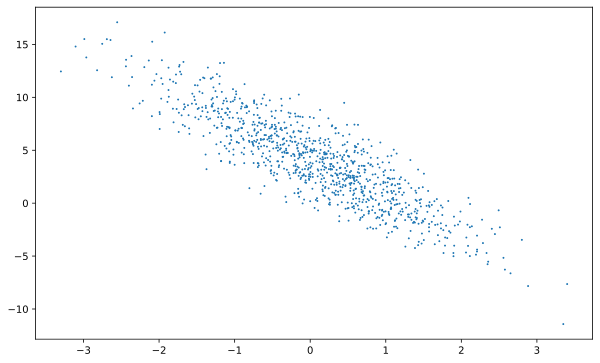

In [ ]:
def use_svg_display():
  #Display in vector graphics
  display.set_matplotlib_formats('svg') #  벡터 그래픽 형식으로, 고해상도에서도 선명하게 그래프를 표시

def set_figsize(figsize=(3.5, 2.5)): # 기본 그래프 크기 설정
  use_svg_display()
  #Set the size of the graph to be plotted
  plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.figure(figsize = (10, 6)) #새로운 그래프를 생성하며, 크기를 (10, 6) 인치로 설정. 기본 크기 설정을 덮어씀
plt.scatter(features[:,1].asnumpy(), labels.asnumpy(),1); # 산점도를 생성

In [ ]:
#This function has been saved in the d2l package for future use

def data_iter(batch_size, features, labels): # 이 함수를 통해 데이터셋을 작은 배치 단위로 나누어 처리가능
  num_examples = len(features) # 샘플 개수
  indices = list(range(num_examples)) #데이터셋의 인덱스를 리스트로 만든다. 예를 들면 1000을 [0,1,2,,,999]
  #The examples are read at random, in no particular order
  random.shuffle(indices) # 샘플의 순서를 랜덤하게 섞음
  for i in range(0, num_examples, batch_size): # batch size간격으로 반복. 예를 들면 batch_size가 10이면 num_examples가 1000이면 i는 0,10,20,,990
    j = nd.array(indices[i: min(i + batch_size, num_examples)]) # 현재 배치의 인덱스를 선택. 마지막 배치는 데이터의 끝에 도달할 수 있으므로 min(i + batch_size, num_examples)로 범위 제한
    yield features.take(j), labels.take(j) # 현재 배치의 특성과 레이블 잔환. take 함수는 주어진 인덱스에 해당하는 요소를 선택
    # The "take" function will then return the corresponding element based on the indices

In [ ]:
batch_size = 10 # 배치크기 10으로 설정
for x, y in data_iter(batch_size, features, labels): # 함수로 부터 배치단위 데이터를 반복적으로 받아옴 (feature, label)
  print(x,y)
  break


[[-0.09838036 -0.08484158]
 [-0.86253977 -0.9446958 ]
 [ 0.4150143  -0.06001255]
 [ 0.23053697  0.3939894 ]
 [ 0.42352363 -1.2845391 ]
 [-1.3782892  -0.26404357]
 [ 1.3119982  -1.9628009 ]
 [ 0.33881238 -0.91140795]
 [-0.7650265   1.2564026 ]
 [ 0.8806273   1.9885163 ]]
<NDArray 10x2 @cpu(0)> 
[ 4.2787137   5.693961    5.251298    3.3174343   9.426568    2.344126
 13.5025215   7.9889784  -1.599349   -0.79267985]
<NDArray 10 @cpu(0)>


In [ ]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1)) # 표준편차(scale)가 0.01인 정규분포를 따르는 난수값들로 가중치 초기화
b = nd.zeros(shape=(1,)) # 편향 0으로 초기화

In [ ]:
# w와 b에 대한 기울기를 추적하고 저장할 수 있도록 한다
w.attach_grad()
b.attach_grad()

In [ ]:
def linreg(x,w,b) :
  return nd.dot(x,w) + b # nd.dot 함수는 행렬 곱셈을 수행
  # y=x⋅w+b를 계산

In [ ]:
def squared_loss(y_hat, y): # 예측값과 실제값 사이의 손실 계산
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
  # 예측값과 실제값 사이의 차이의 제곱을 계산하여 손실을 구한다
  #y의 형태를 y_hat의 형태와 일치시키기 위해 재구성. 오차 제곱을 반으로 나누어 평균 제곱 오차의 기본형식 따름

In [ ]:
# 파라미터를 업데이트하는 함수
def sgd(params, lr, batch_size): # params는 업데이트할 모델 파라미터들의 리스트. w와b등이 포함
  for param in params: # 파라미터를 하나씩 꺼냄
    param[:] = param - lr * param.grad / batch_size

In [ ]:
lr = 0.03 #학습률
num_epochs = 3 #학습 횟수
net = linreg #모델
loss = squared_loss # 0.5 (y-y')^2

for epoch in range(num_epochs): #학습 횟수만큼 반복
  for x, y in data_iter(batch_size, features, labels): # 데이터셋을 배치 단위로 반복
    with autograd.record(): # 자동미분 (autograd)을 사용하여 기울기를 계산
      l = loss(net(x, w, b), y) # 예측값과 실제값 사이의 손실 계산
    l.backward() # 손실의 기울기를 계산
    sgd([w, b], lr, batch_size) # 파라미터 업데이트
  train_l = loss(net(features, w, b), labels) #학습 손실 계산
  print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy())) # 손실의 평균값을 NumPy 배열로 변환하여 출력

epoch 1, loss 0.040683
epoch 2, loss 0.000157
epoch 3, loss 0.000050


In [ ]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w 
[ 3.2305717e-05 -2.1290779e-04]
<NDArray 2 @cpu(0)>
Error in estimating b 
[0.00046778]
<NDArray 1 @cpu(0)>
